In [1]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

from models.pipeline import Pipeline
from utils.view import draw_grid
from utils.latent_space import grid_to_latent, latent_to_grid, reconstruct_grid
from utils.latent_space_clusters import sample_nearby, find_matching_example_grid_id, prepare_latent_data, label_decoded_samples

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v2_vampprior import ConvolutionalVAEV2_VampPrior
from models.convolutional_vae_v2_vampprior import preprocess_grid as preprocess_grid_vp, postprocess_grid as postprocess_grid_vp
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=512,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_512_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [3]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [4]:
def extract_single_object_grids(grid):
    unique_digits = np.unique(grid)
    unique_digits = unique_digits[unique_digits != 0]

    object_grids = []
    for digit in unique_digits:
        mask = (grid == digit).astype(int) * digit
        object_grids.append(mask)

    return object_grids

In [5]:
puzzle_id = 'e21a174a'

task = data[puzzle_id]

train_pairs = task['train']
test_pair = task['test'][0]

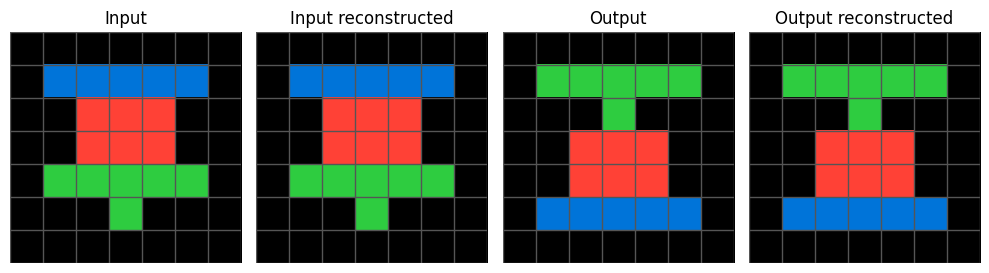

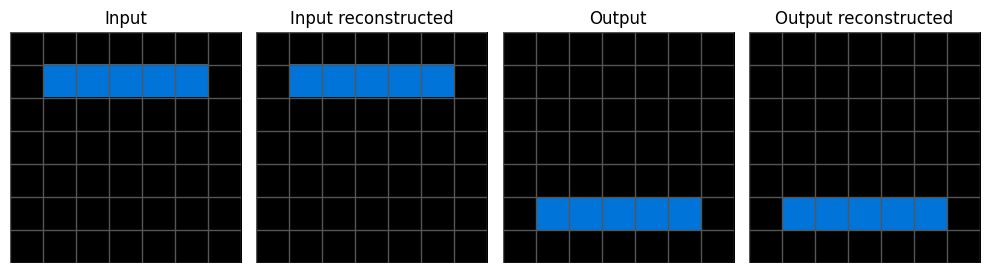

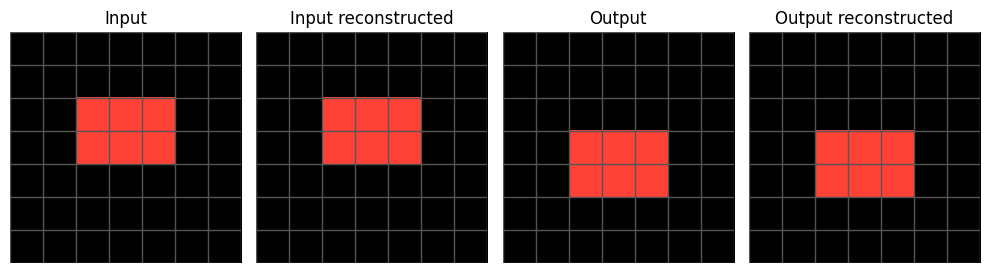

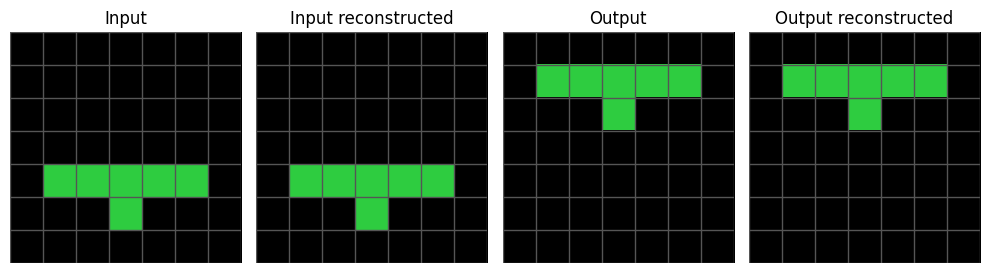

In [6]:
input, output = train_pairs[2]

input_objects = extract_single_object_grids(input)
inputs = [input] + input_objects

output_objects = extract_single_object_grids(output)
outputs = [output] + output_objects

object_translations = []

for (input, output) in zip(inputs, outputs):
    inp_recon = reconstruct_grid(pipeline, input, model_type)
    out_recon = reconstruct_grid(pipeline, output, model_type)
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    draw_grid(axs[0], input, title="Input")
    draw_grid(axs[1], inp_recon, title="Input reconstructed")
    draw_grid(axs[2], output, title="Output")
    draw_grid(axs[3], out_recon, title="Output reconstructed")
    
    plt.tight_layout()
    plt.show()

In [7]:
original_translations = []
object_translations = []

for idx, (input, output) in enumerate(zip(input_objects, output_objects)):
    z_input, _ = grid_to_latent(pipeline, input, model_type)
    z_output, _ = grid_to_latent(pipeline, output, model_type)
    z_diff = (z_output - z_input).squeeze(0)

    original_translations.append(z_diff.detach().cpu().numpy())

    for i in range(z_diff.size(0)):
        temp = z_diff.clone()
        temp[i] = 0
        candidate_output = latent_to_grid(pipeline, z_input + temp, output, model_type)

        if (output == candidate_output).mean() == 1.0:
            z_diff[i] = 0

    object_translations.append(z_diff.detach().cpu().numpy())
    print(f"Number of relevant dimensions in training pair #{idx}: ", torch.count_nonzero(z_diff).item())


Number of relevant dimensions in training pair #0:  173
Number of relevant dimensions in training pair #1:  200
Number of relevant dimensions in training pair #2:  184


In [8]:
example_grids_1 = np.array([
    [[0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0]]
])

z_example_grids_1 = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in example_grids_1], dim=0)

In [9]:
z_all = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for task in data.values() for pair in task['train'] + task['test'] for grid in pair],dim=0)

In [10]:
def visualize_grid_sequence_with_clusters(
        z_example, z_all, z_matched_samples, matched_labels, visualise_all=False, umap_metric='euclidean'):
    reducer = umap.UMAP(
        n_components=2, 
        min_dist=0.0,
        n_neighbors=15,
        metric=umap_metric, 
        random_state=42
    )
    latent_2d = reducer.fit_transform(z_all)
    latent_example_2d = reducer.transform(z_example)

    if visualise_all:
        x_range = latent_2d[:, 0].max() - latent_2d[:, 0].min()
        y_range = latent_2d[:, 1].max() - latent_2d[:, 1].min()
    else:
        x_range = latent_example_2d[:, 0].max() - latent_example_2d[:, 0].min()
        y_range = latent_example_2d[:, 1].max() - latent_example_2d[:, 1].min()

    scale = (x_range + y_range) / 2
    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.05 * scale
    offset = 0.05 * scale
    plt.figure(figsize=(8, 6))

    if visualise_all:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='gray', s=10, label="Other points")
    plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], c='blue', s=10, label="Example points")

    cmap = plt.get_cmap('tab20')
        
    for i, label in enumerate(matched_labels):
        matched_2d = reducer.transform(z_matched_samples[i].reshape(1, -1))[0]
        plt.scatter(matched_2d[0], matched_2d[1], c=cmap(label % 20), s=10, label=f"Sample {label}")

    for i in range(len(latent_example_2d) - 1):
        start = latent_example_2d[i]
        end = latent_example_2d[i + 1]
        plt.arrow(start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True, color='black', alpha=0.8)

    for i, (x, y) in enumerate(latent_example_2d):
        plt.text(x + offset, y + offset, str(i + 1), fontsize=10, color='black')
        
    legend_entries = {}
    for label in set(matched_labels):
        color = cmap(label % 20)
        legend_entries[f"Sample {label}"] = color

    handles = [mpatches.Patch(color=color, label=name) for name, color in legend_entries.items()]
    plt.legend(handles=handles, title="Matched Samples")
    plt.title(f"Latent Space Trajectory (UMAP {umap_metric})")
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



In [11]:
z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_1, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_1, pipeline, model_type)

# visualize_grid_sequence_with_clusters(
#     z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric='euclidean'
# )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


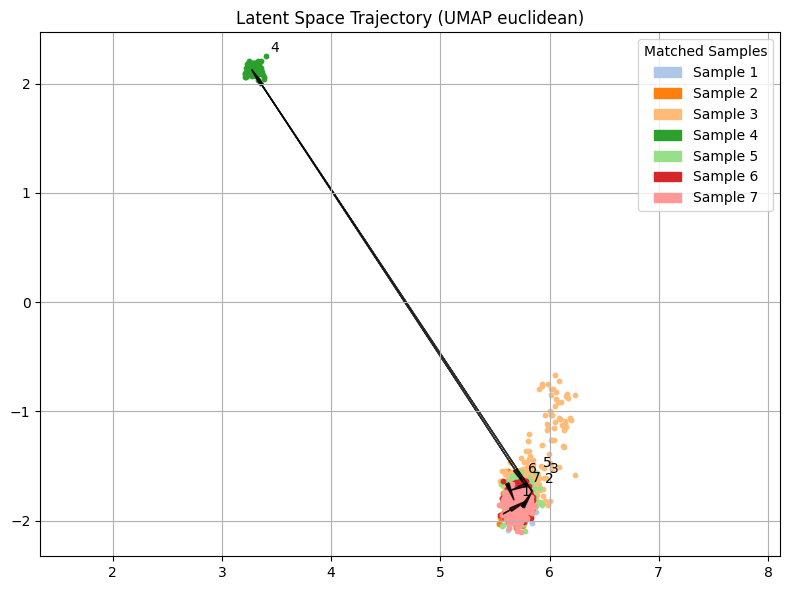

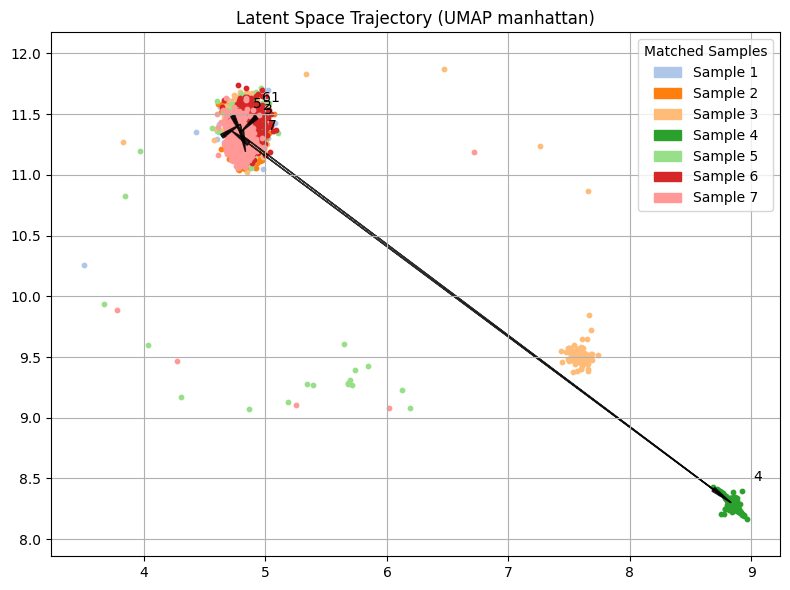

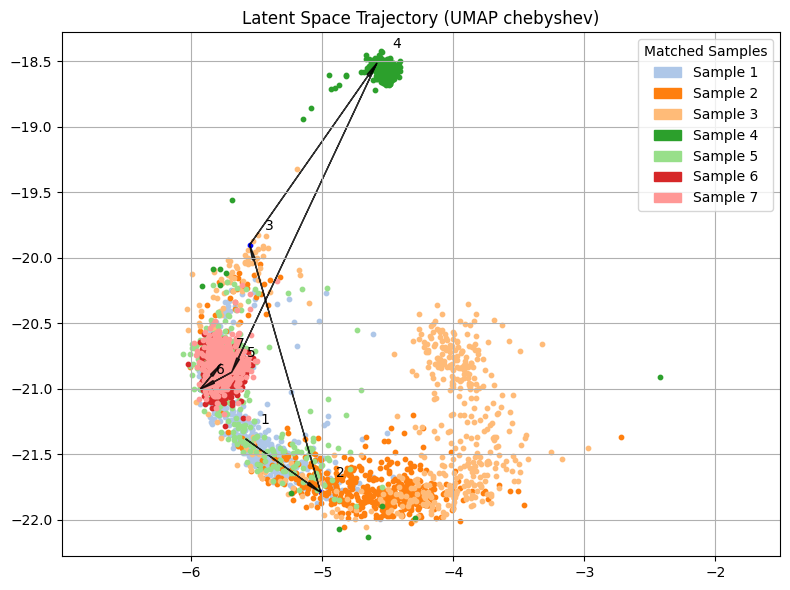

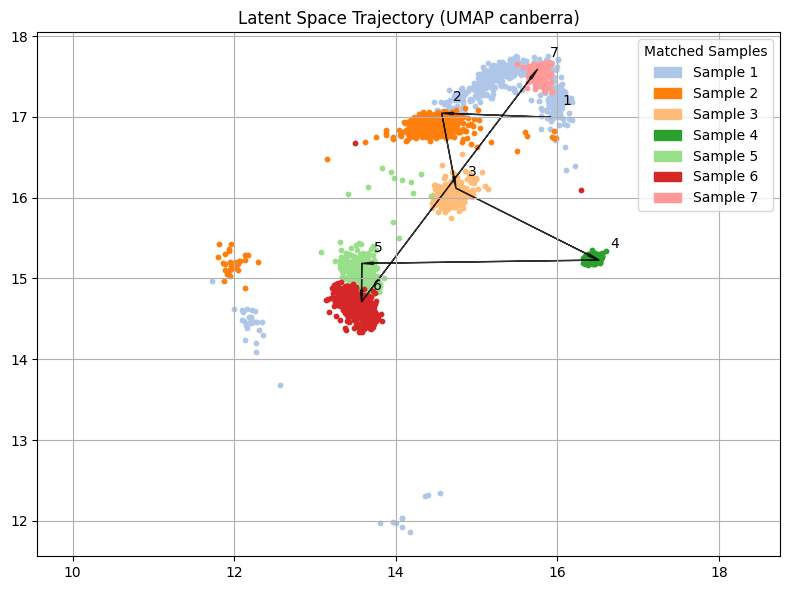

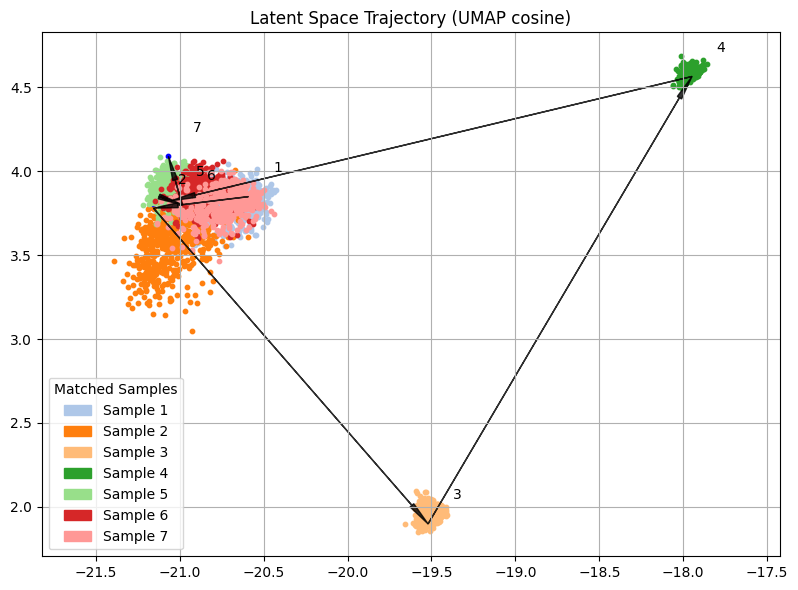

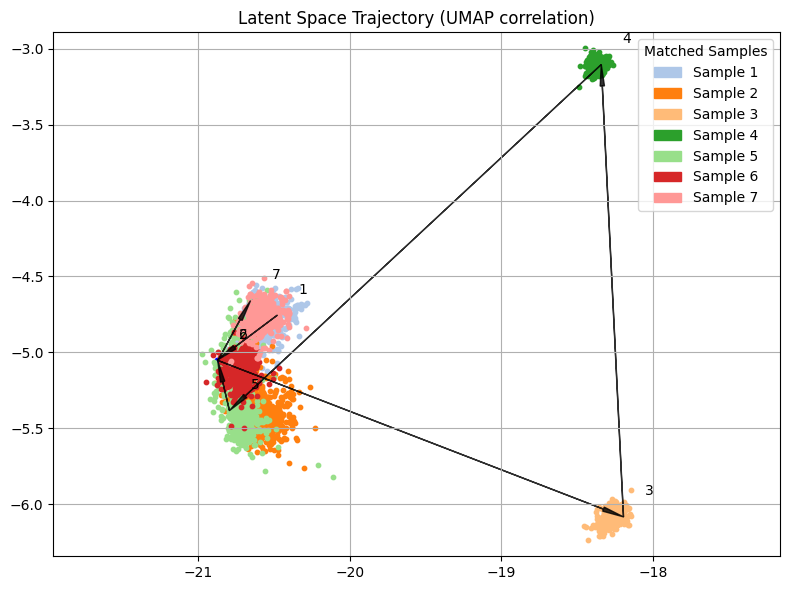

In [ ]:
umap_metrics = [
    # # Basic metrics
    "euclidean",
    # "manhattan", # not relevant
    # "chebyshev", # not relevant
    # "minkowski", # a bit slow

    # # Miscellaneous spatial metrics
    "canberra", # very good 
    # "braycurtis",
    # "haversine", # error

    # # Normalized spatial metrics
    # "mahalanobis", # veeeery slow
    # "wminkowski", # slow 
    # "seuclidean", # error

    # Angular and correlation metrics
    "cosine",
    "correlation",

    # Metrics for binary data - irrelevant
    # "hamming",
    # "jaccard",
    # "dice",
    # "russellrao",
    # "kulsinski",
    # "rogerstanimoto",
    # "sokalmichener",
    # "sokalsneath",
    # "yule"
]

for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

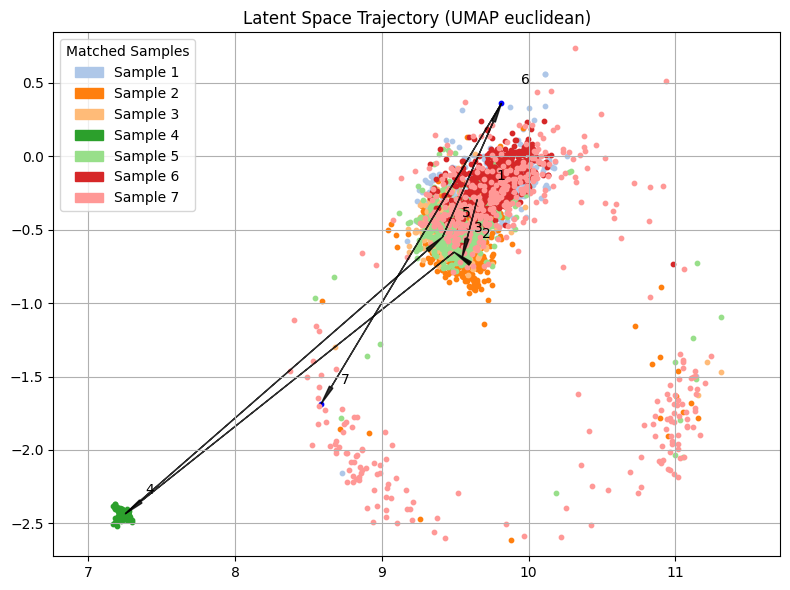

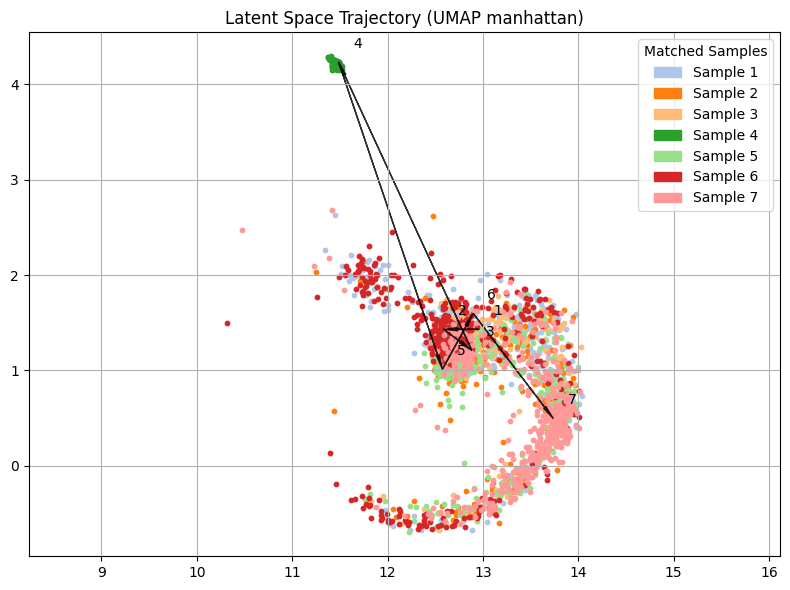

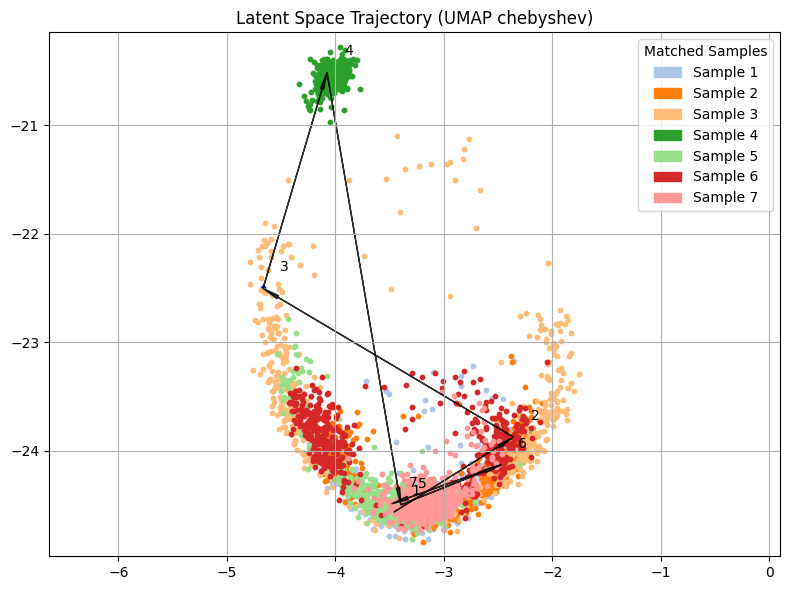

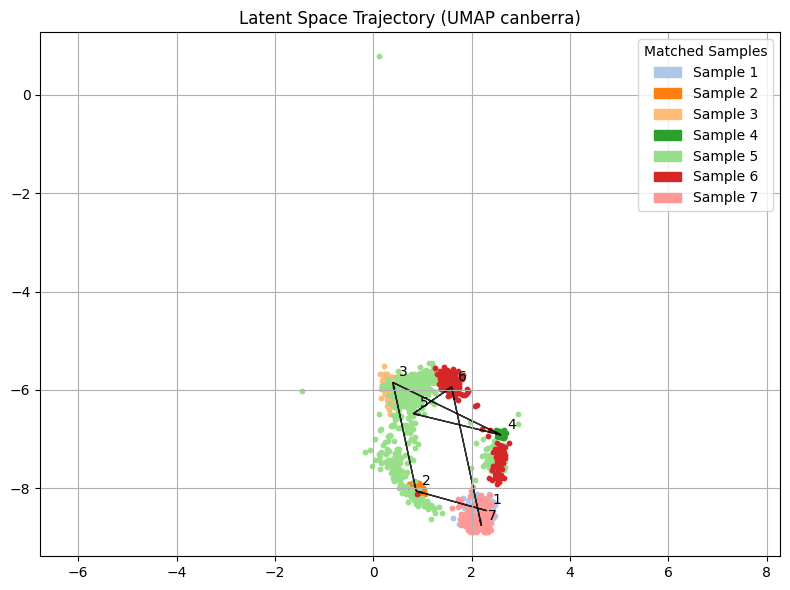

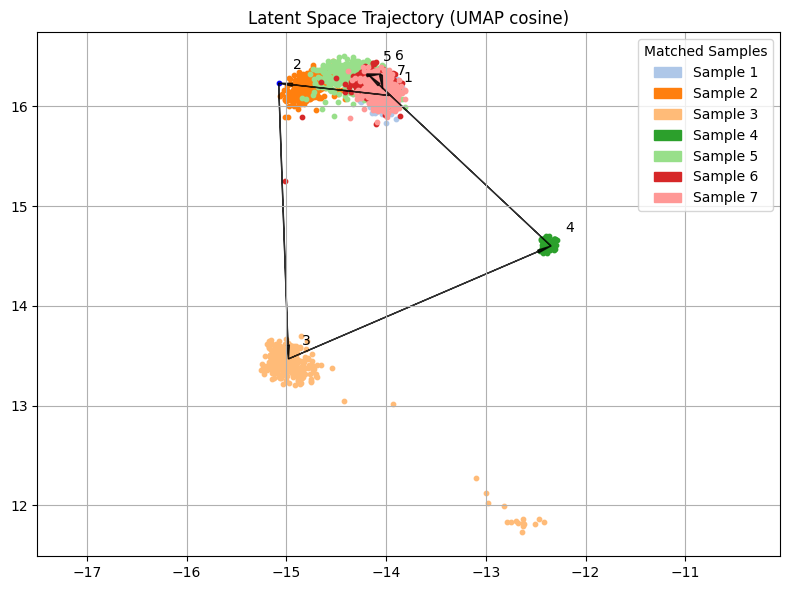

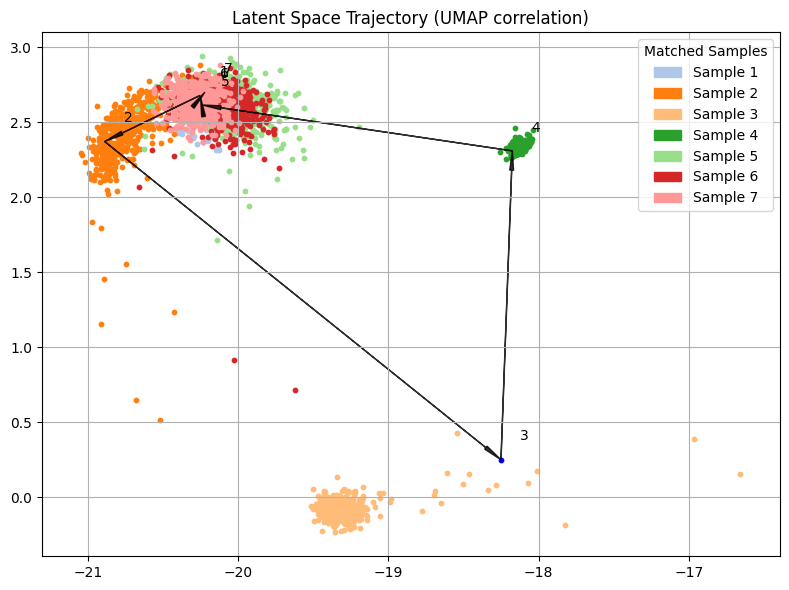

In [ ]:
def change_color(grid, old_color, new_color):
    grid = np.array(grid)
    grid[grid == old_color] = new_color
    return grid

example_grids_2 = change_color(example_grids_1, 1, 2)
z_example_grids_2 = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in example_grids_2], dim=0)

z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_2, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_2, pipeline, model_type)

for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue


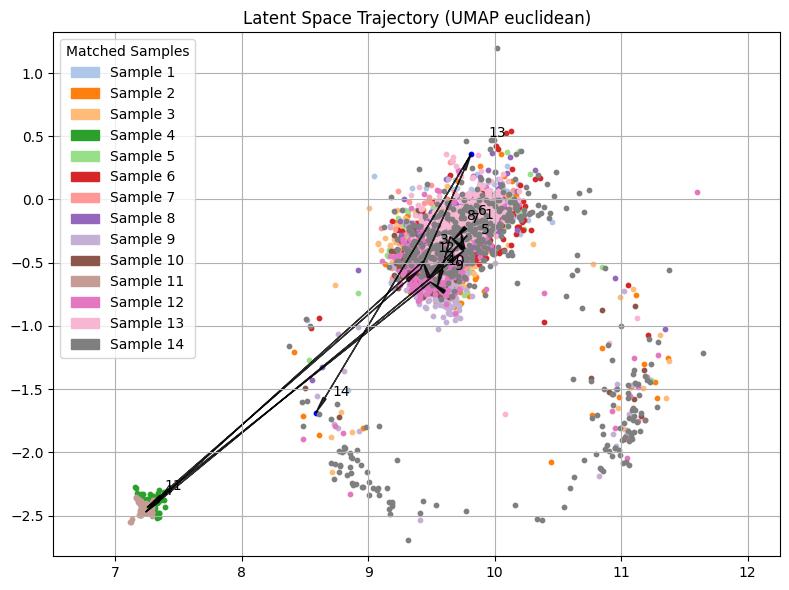

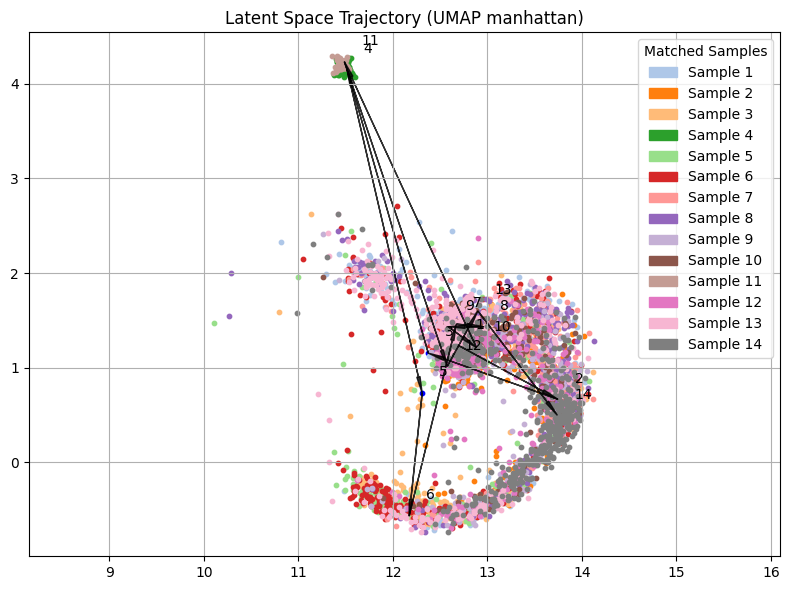

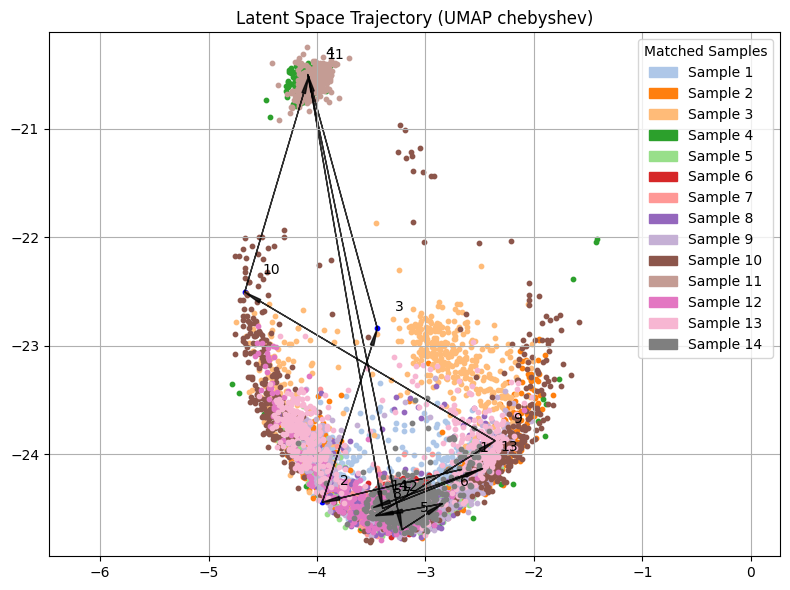

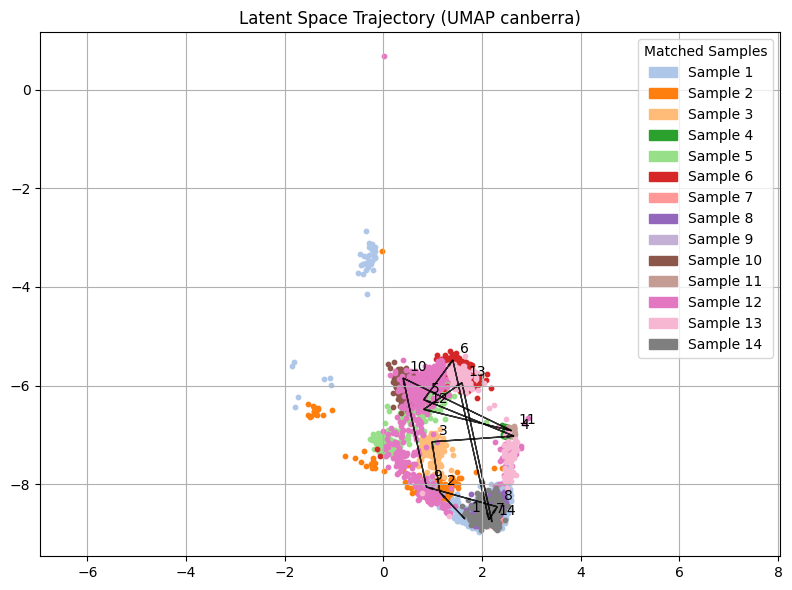

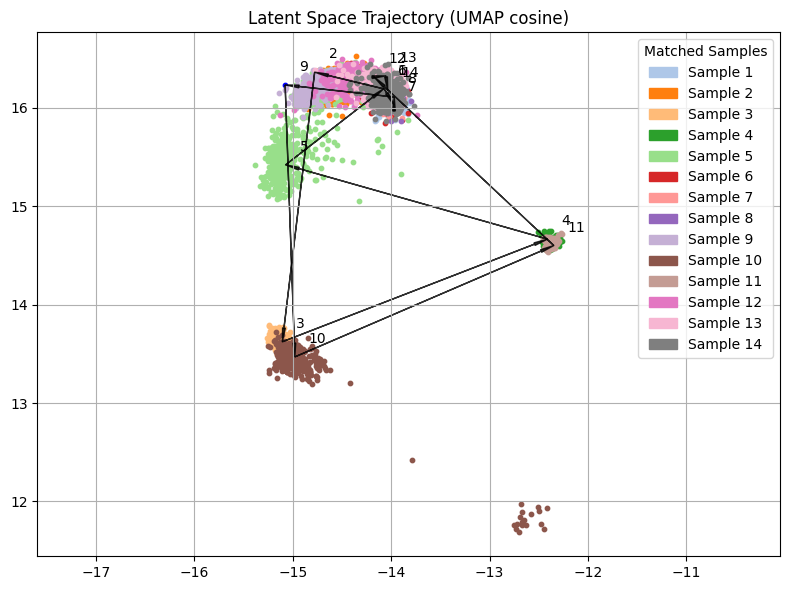

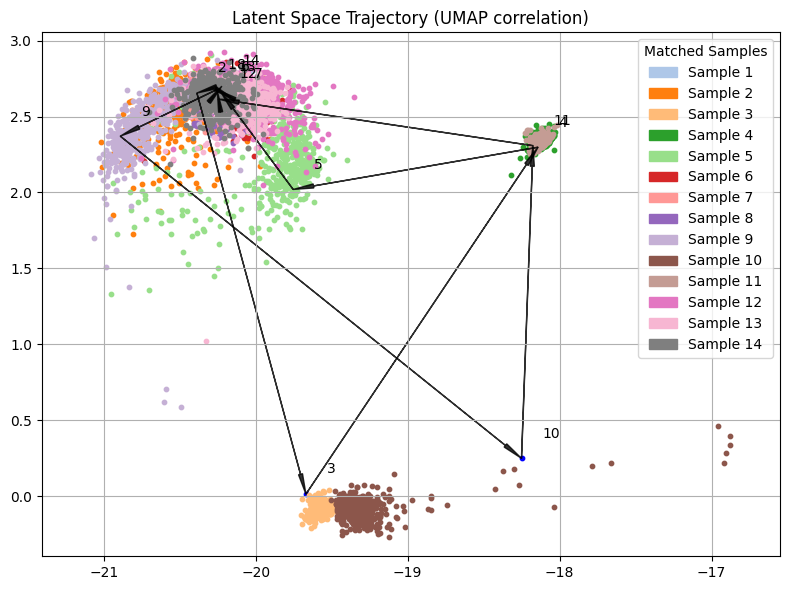

In [ ]:
example_grids_3 = np.concatenate([example_grids_1, example_grids_2], axis=0)
z_example_grids_3 = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in example_grids_3], dim=0)
z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_3, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_3, pipeline, model_type)
for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

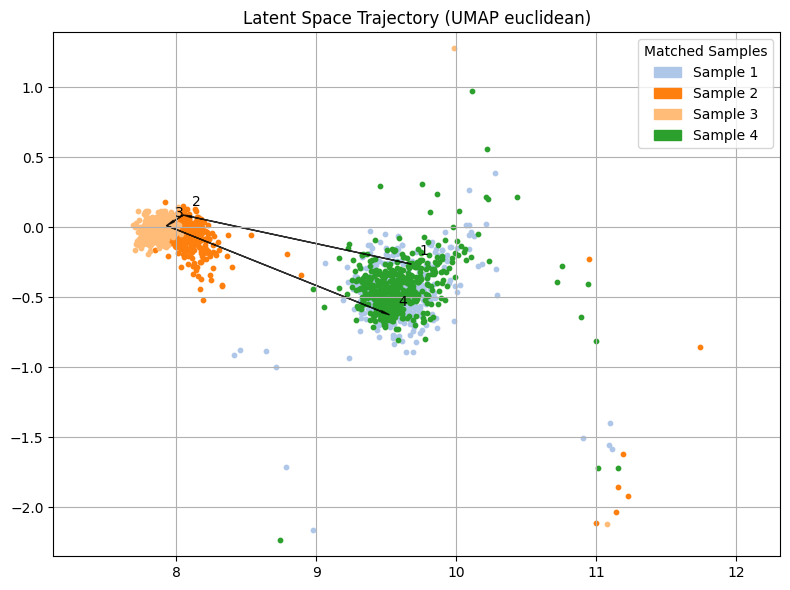

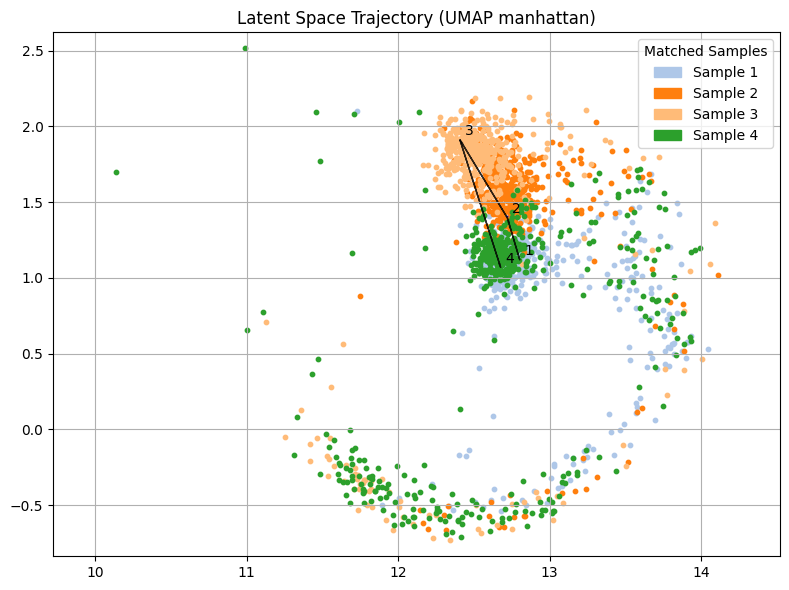

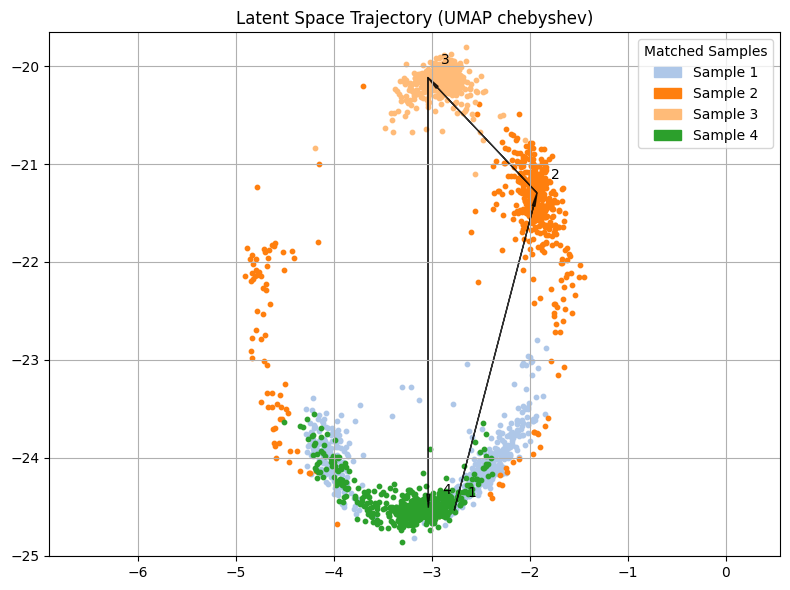

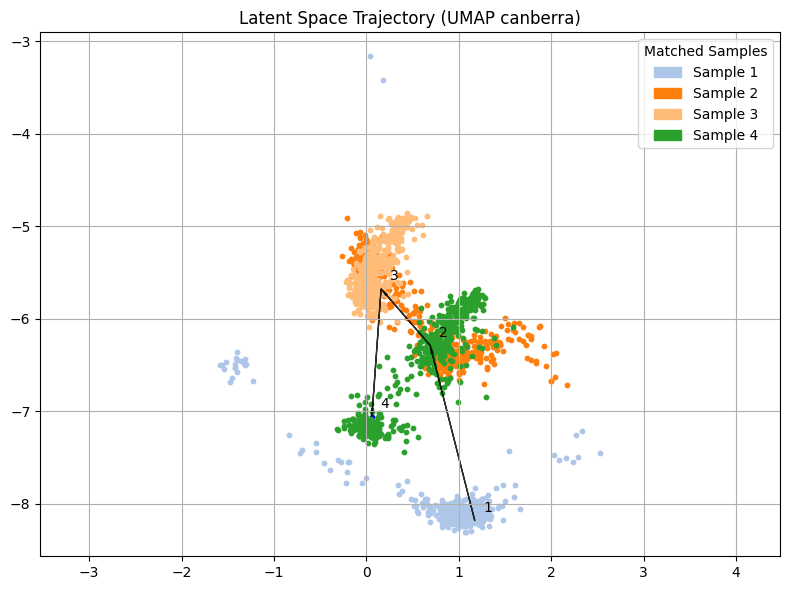

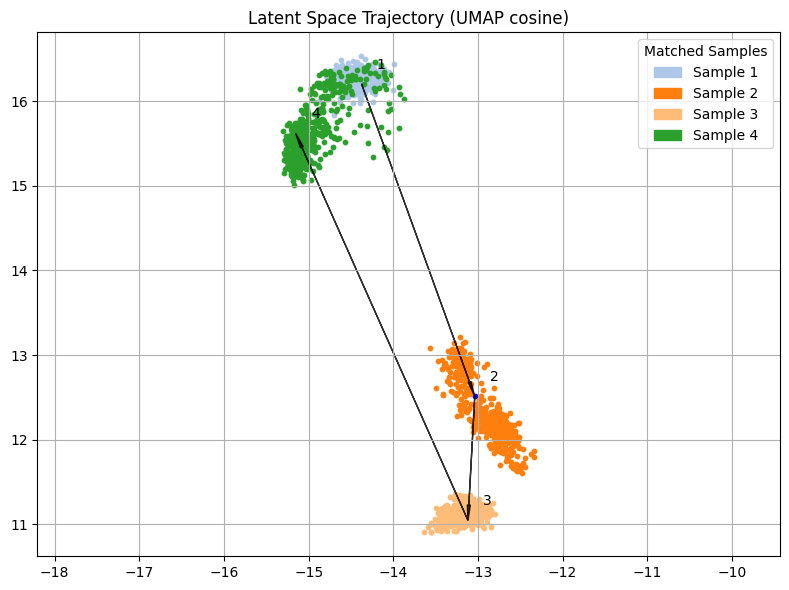

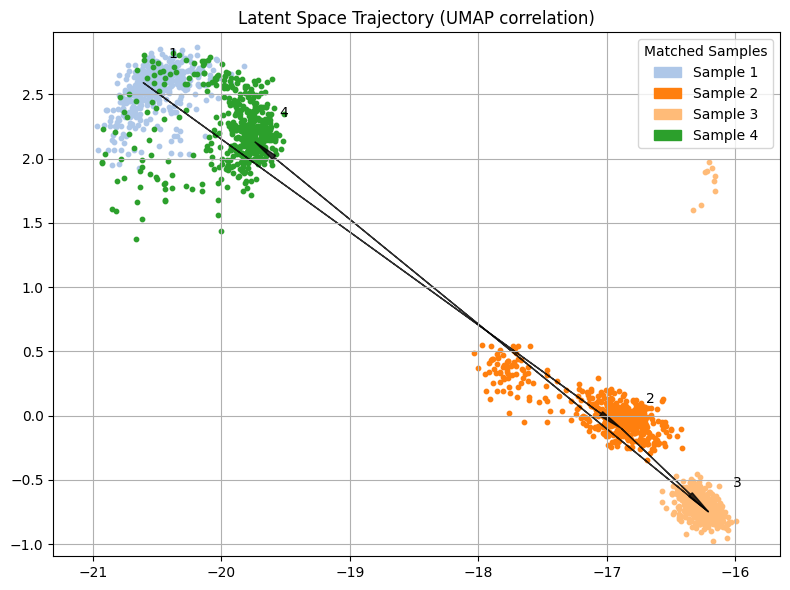

In [ ]:
example_grids_4 = np.array([

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],
    
    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],
])

z_example_grids_4 = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in example_grids_4], dim=0)

z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_4, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_4, pipeline, model_type)
for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

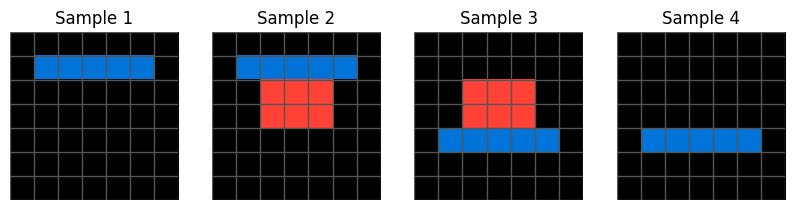

In [179]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
for idx, grid in enumerate(example_grids_4):
    draw_grid(axs[idx], grid, title=f"Sample {idx + 1}")
